In [1]:
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler

In [2]:
# Load the Fashion MNIST Dataset
fashion = fetch_openml("Fashion-MNIST", version=1, as_frame=False)
X, y = fashion['data'], fashion['target']

print("Shape of feature matrix:",X.shape)
print("Shape of target labels:",y.shape)


Shape of feature matrix: (70000, 784)
Shape of target labels: (70000,)


In [3]:
# Normalize Data
X = X / 255.0       # pixel normalization
y = y.astype(int)   # convert labels to integers

In [4]:
import matplotlib.pyplot as plt

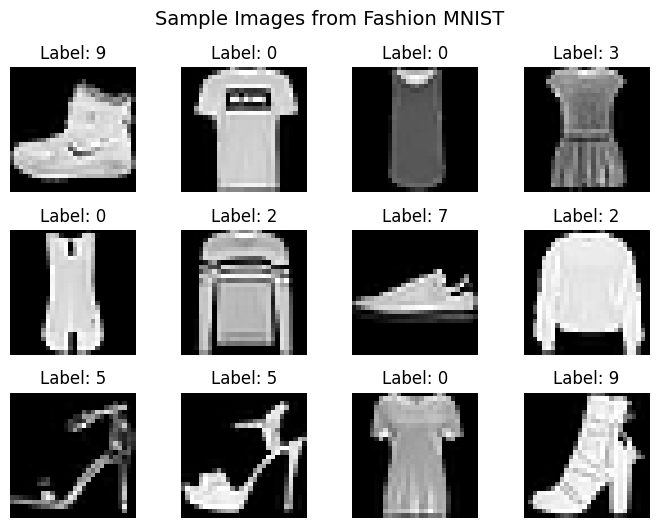

In [5]:
# Preview some images
plt.figure(figsize=(7, 7))
for i in range(12):
    plt.subplot(4, 4, i + 1)
    plt.imshow(X[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title(f"Label: {y[i]}")
plt.suptitle("Sample Images from Fashion MNIST", fontsize=14)
plt.tight_layout()
plt.show()


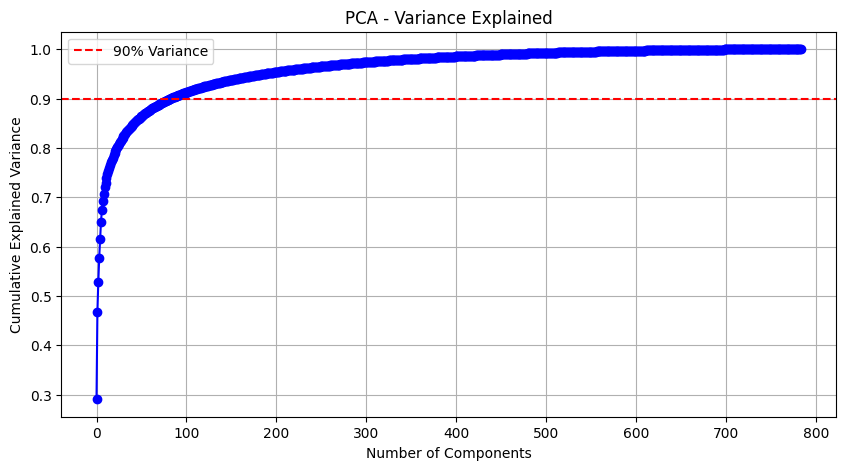

In [6]:
from sklearn.decomposition import PCA

# Apply PCA - First fit on full data to check Varience Ratio
pca = PCA().fit(X)

# Explained Variance Ratio
explained_var = np.cumsum(pca.explained_variance_ratio_)

# Plot Explained Variance
plt.figure(figsize=(10,5))
plt.plot(explained_var, marker='o', color='blue')
plt.axhline(y=0.90, color='r', linestyle='--', label="90% Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA - Variance Explained")
plt.grid(True)
plt.legend()
plt.show()


In [7]:
# How many components explain 90% variance?
components_90 = np.argmax(explained_var >= 0.90) + 1
print(f"Number of components to retain 90% variance: {components_90}")

Number of components to retain 90% variance: 84


In [8]:
# Reduce dimensionality to 50 for clustering
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Try cluster counts from 2 to 10
inertia = []
sil_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)
    score = silhouette_score(X_pca, kmeans.labels_)
    sil_scores.append(score)
    print(f"k={k} -> Silhouette Score: {score:.4f}")

k=2 -> Silhouette Score: 0.4037
k=3 -> Silhouette Score: 0.4449
k=4 -> Silhouette Score: 0.4428
k=5 -> Silhouette Score: 0.4204
k=6 -> Silhouette Score: 0.4120
k=7 -> Silhouette Score: 0.4112
k=8 -> Silhouette Score: 0.4290
k=9 -> Silhouette Score: 0.4154
k=10 -> Silhouette Score: 0.4027


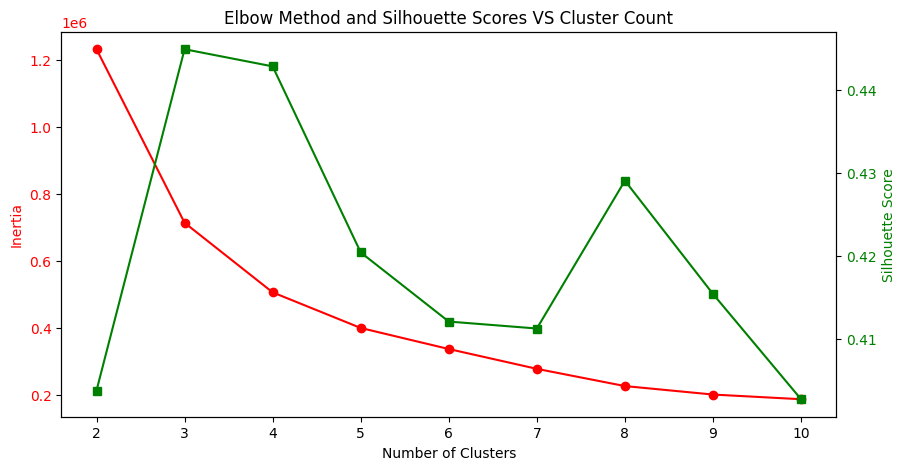

In [10]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# Elbow Method
ax1.plot(range(2,11), inertia, marker='o', color='red', label='Inertia')
ax1.set_xlabel("Number of Clusters")
ax1.set_ylabel("Inertia", color='red')
ax1.tick_params(axis="y", labelcolor='red')

#Silhouette Scores
ax2 = ax1.twinx()
ax2.plot(range(2, 11), sil_scores, marker='s', color='green', label="Silhouette Scores")
ax2.set_ylabel("Silhouette Score", color='green')
ax2.tick_params(axis="y", labelcolor='green')

plt.title("Elbow Method and Silhouette Scores VS Cluster Count")
plt.show()


In [11]:
# Final KMeans Clustering
optimal_k = 10
kmeans_final = KMeans(optimal_k, random_state=42)
clusters_kmeans = kmeans_final.fit_predict(X_pca)

print("KMeans clustering complete with k =", optimal_k)

KMeans clustering complete with k = 10


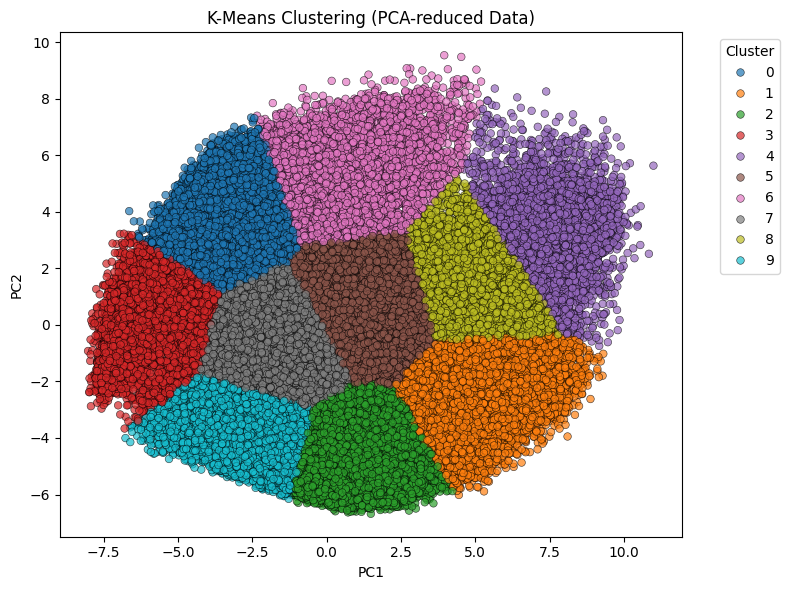

In [12]:
import seaborn as sns

# Visualize Clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters_kmeans, palette='tab10', s=30, alpha=0.7, edgecolor='black')
plt.title("K-Means Clustering (PCA-reduced Data)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1),loc='upper left')
plt.tight_layout()
plt.show()

In [13]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Apply DBSCAN
dbscan = DBSCAN(eps=3, min_samples=5)
db_labels = dbscan.fit_predict(X_pca)

#Check unique Clusters
n_clusters_db = len(np.unique(db_labels)) - (1 if -1 in db_labels else 0)
print("Number of clusters found by DBSCAN:", n_clusters_db)

n_noise = list(db_labels).count(-1)
print("Number of noise points:", n_noise)


Number of clusters found by DBSCAN: 1
Number of noise points: 0


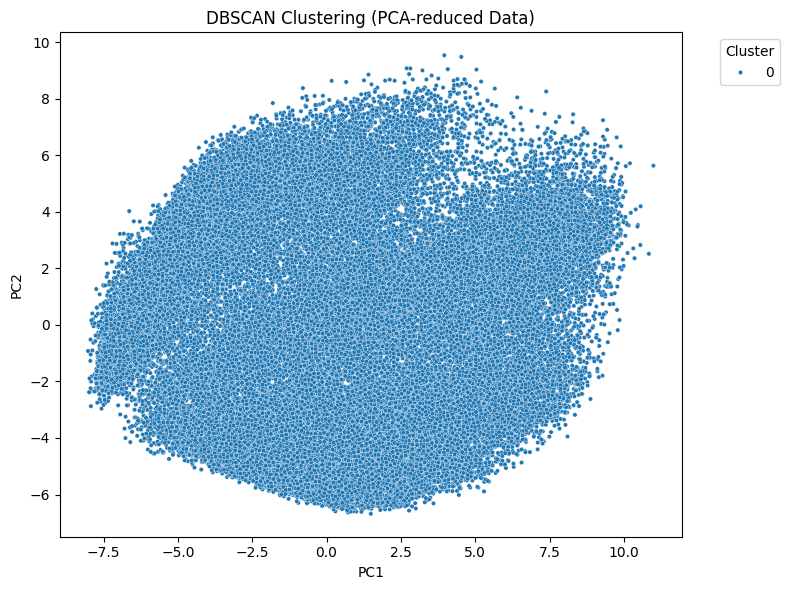

In [14]:
# Visualize DBSCAN
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=db_labels, palette='tab10', s=10)
plt.title("DBSCAN Clustering (PCA-reduced Data)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1),loc='upper left')
plt.tight_layout()
plt.show()

In [15]:
#Evaluate KMeans
sli_kmeans = silhouette_score(X_pca, clusters_kmeans)
db_kmeans = davies_bouldin_score(X_pca, clusters_kmeans)

# Evaluation: DBSCAN (ignoring noise points -1)
mask = db_labels != -1
if len(np.unique(db_labels[mask])) > 1:
    db_silhouette = silhouette_score(X_pca[mask], db_labels[mask])
    db_db = davies_bouldin_score(X_pca[mask], db_labels[mask])
else:
    db_silhouette = db_db = None

# Display result
print("*****Clustering Evaluation*****")
print(f"KMeans Silhouette Score: {sli_kmeans:.4f}, DB Index: {db_kmeans:.4f}")
print(f"DBSCAN Silhouette Score: {db_silhouette if db_silhouette else 'N/A'}, DB Index: {db_db if db_db else 'N/A'}")

*****Clustering Evaluation*****
KMeans Silhouette Score: 0.4027, DB Index: 0.8023
DBSCAN Silhouette Score: N/A, DB Index: N/A
